In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00


In [1]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import pyarrow as pa
from statistics import mean

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
!nvidia-smi

Tue Jan 30 07:59:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
#name_dir = 'all_authors/'
name_dir = 'drive/MyDrive/Colab Notebooks/Классификация авторов/HashingVectorizer/datasets(texts)/'
name_file_train_sent = 'train_authors_texts.csv'
name_file_val_sent = 'val_authors_texts.csv'
name_file_test_sent = 'test_authors_texts.csv'

In [6]:
random_state = 42
test_size = 0.2 #размер тестовой части
val_size = 0.2 #размер валидационной части
max_len = 512 #максимальная длина входной последовательности
decrease_tokens = 100 #количество токеов на которое уменьшается максимальная длина до достижения порогового значения
part_clipped_texts = 0.01 #пороговое значение количества обрезанных текстов
model_name = 'intfloat/multilingual-e5-large'
num_author = 18

In [10]:
#Training arguments
output_dir='./results_e5_large_ru_disbalanced_10_epochs'
overwrite_output_dir=True
save_strategy='epoch'
num_train_epochs=10
per_device_train_batch_size=16
per_device_eval_batch_size=16
weight_decay=0.01
learning_rate=1e-5
logging_dir='./logs'
evaluation_strategy='epoch'

# Загрузка корпуса авторских предложений

In [7]:
df_train = pd.read_csv(name_dir+name_file_train_sent, sep='\t')
df_val = pd.read_csv(name_dir+name_file_val_sent, sep='\t')
df_test = pd.read_csv(name_dir+name_file_test_sent, sep='\t')

In [8]:
df_train

,text,author,label
0,Сжигали коммунисты партбилеты.\nПопрятались в ...,Александр Проханов,10
1,"Denken Sie darüber nach, warum der Westen hier...",Gerhard Wirth,2
2,"Касаюсь рукой седого уральского камня, словно ...",Александр Проханов,10
3,He ain't wrong.\nIt's not every day that our l...,Markos Moulitsas,6
4,Свободная касса!\nВы - в Макдональдсе. Что зак...,Артемий Лебедев,11
...,...,...,...
12109,الحجُّ أحد أركان الإسلام الخمسة، فُرض في العام...,علي الصلابي,16
12110,Von Jastra Kranjec\nTrotz der drohenden Bedroh...,Gerhard Wirth,2
12111,Uno de los temas centrales del artículo de Mar...,Abel Fernández,0
12112,Macron annonce un referendum pour introduire u...,Jean-Luc Mélenchon,4


In [9]:
df_val

,text,author,label
0,Олег Дмитриевич Бакланов — человек блистательн...,Александр Проханов,10
1,"Hello, everyone! In this newfound age of socia...",Markos Moulitsas,6
2,A longtime reader who comments under the name ...,Rod Dreher,9
3,⚡️За результатами сьогоднішнього засідання Ком...,Данило Гетманцев,12
4,Un article de Henry Bonner\nLa manie pour les ...,H16,3
...,...,...,...
1491,"Türkiye, bölgedeki çok karmaşık dengeler içind...",Oral Çalışlar,8
1492,No estoy muy seguro de porqué me siento impuls...,Abel Fernández,0
1493,El olor a cadáver obra milagros en política. ¿...,José García Domínguez,5
1494,(cliquear encima para ampliar)\nGracias a Stur...,Abel Fernández,0


In [10]:
df_test

,text,author,label
0,💁🏻‍♂️Щодо зайвої дискусії про необхідність под...,Данило Гетманцев,12
1,"From an unlikely source - The Pillar, a terrif...",Rod Dreher,9
2,Cumpliendo con lo que prometí en el posteo ant...,Abel Fernández,0
3,Ексклюзив. Героїчна 93 бригада поблизу Бахмуту...,Сергій Стерненко,14
4,"Когда я был маленьким, бабушка варила мне с бр...",Артемий Лебедев,11
...,...,...,...
1341,Reader Eric Wearne writes:,Rod Dreher,9
1342,В поездке по Дагестану я посетил многие святые...,Александр Проханов,10
1343,Uno no tiene tiempo para los análisis político...,Abel Fernández,0
1344,"Cette semaine, le traité de libre-échange avec...",Jean-Luc Mélenchon,4


# Размер данных

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
def get_token_len(df, tokenizer):
    token_lens = []
    # for txt in df.sentence:
    for txt in df.text:
        tokens = tokenizer.encode(txt)
        token_lens.append(len(tokens))
    return token_lens

In [21]:
def token_len(token_lens, max_len):
    number_outliers = sum(length > max_len for length in token_lens)
    print(f'min length = {min(token_lens)} tokens')
    print(f'mean length = {mean(token_lens)} tokens')
    print(f'max length = {max(token_lens)} tokens')
    print(f'{number_outliers} texts longer than {max_len} tokens ({number_outliers/len(token_lens)})')
    fig = sns.histplot(token_lens)
    plt.xlabel('Token count')
    plt.show()

In [22]:
def define_max_len(df_train, df_val, df_test, tokenizer, max_len):
    token_lens_train = get_token_len(df_train, tokenizer)
    token_lens_val = get_token_len(df_val, tokenizer)
    token_lens_test = get_token_len(df_test, tokenizer)
    shorten = True
    while shorten:
        number_outliers_train = sum(length > max_len for length in token_lens_train)
        number_outliers_val = sum(length > max_len for length in token_lens_val)
        number_outliers_test = sum(length > max_len for length in token_lens_test)
        part_outliers_train = number_outliers_train/len(df_train)
        part_outliers_val = number_outliers_val/len(df_val)
        part_outliers_test = number_outliers_test/len(df_test)
        if part_outliers_train < part_clipped_texts and part_outliers_val < part_clipped_texts and part_outliers_test < part_clipped_texts:
            max_len -= decrease_tokens
        else:
            max_len += decrease_tokens
            shorten = False
    print('data type: train')
    token_len(token_lens_train, max_len)
    print('\ndata type: validation')
    token_len(token_lens_val, max_len)
    print('\ndata type: test')
    token_len(token_lens_test, max_len)
    print(f'\ndefine max_len = {max_len}')
    return max_len

Token indices sequence length is longer than the specified maximum sequence length for this model (6783 > 512). Running this sequence through the model will result in indexing errors


data type: train
min length = 3 tokens
mean length = 1675.813934290903 tokens
max length = 671949 tokens
6280 texts longer than 612 tokens (0.5184084530295526)


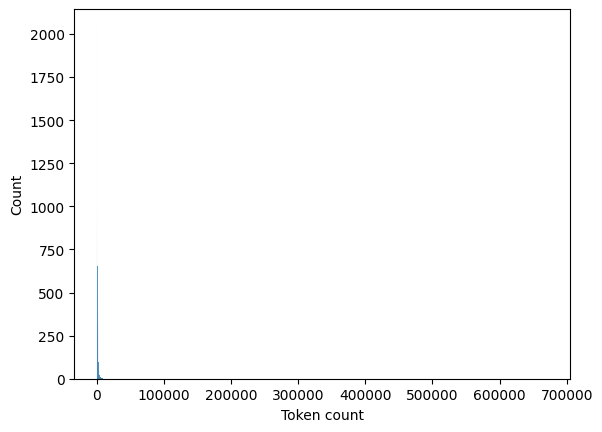


data type: validation
min length = 6 tokens
mean length = 1612.7332887700534 tokens
max length = 485217 tokens
768 texts longer than 612 tokens (0.5133689839572193)


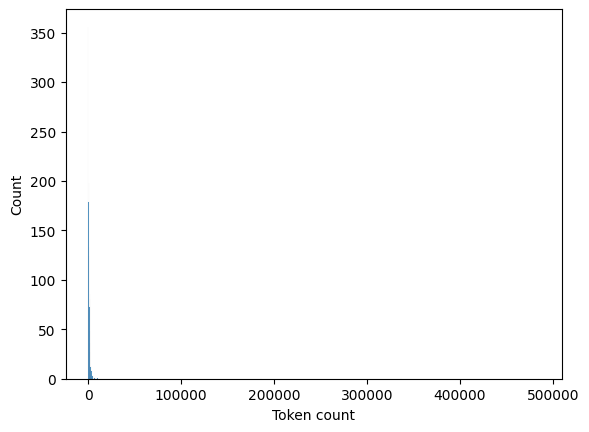


data type: test
min length = 6 tokens
mean length = 1603.467310549777 tokens
max length = 462570 tokens
700 texts longer than 612 tokens (0.5200594353640416)


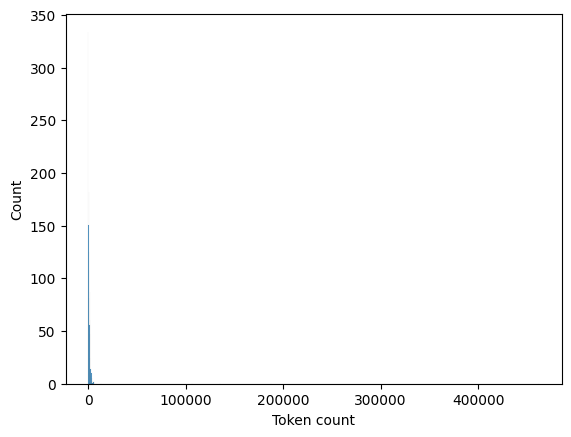


define max_len = 612


In [23]:
max_len = define_max_len(df_train, df_val, df_test, tokenizer, max_len)

In [ ]:
# max_len = 312

In [ ]:
from razdel import tokenize, sentenize
def get_token_len(texts):
    token_lens = []
    # for txt in df.sentence:
    for txt in texts:
        token_lens.append(len(list(sentenize(txt))))
    return token_lens

In [ ]:
def token_len(token_lens):
    print(f'min length = {min(token_lens)} sentences')
    print(f'mean length = {mean(token_lens)} sentences')
    print(f'max length = {max(token_lens)} sentences')
    fig = sns.histplot(token_lens)
    plt.xlim((0, 20))
    plt.xticks(list(range(21)))
    plt.xlabel('Sentence count')
    plt.show()

min length = 3 sentences
mean length = 3.9277614130493426 sentences
max length = 6 sentences


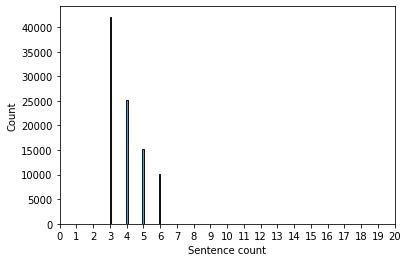

In [ ]:
token_len(get_token_len(list(df_train['text'])))

min length = 3 sentences
mean length = 3.918895298024821 sentences
max length = 6 sentences


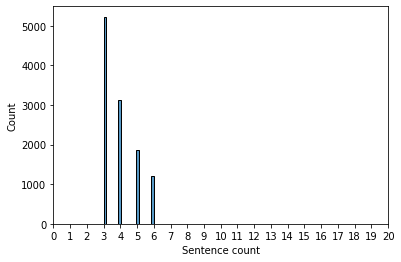

In [ ]:
token_len(get_token_len(list(df_val['text'])))

min length = 3 sentences
mean length = 3.9022140221402215 sentences
max length = 6 sentences


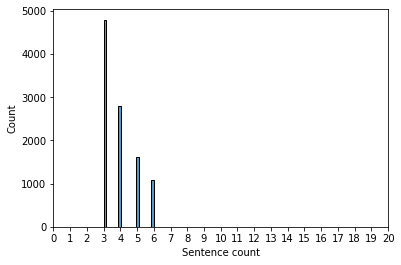

In [ ]:
token_len(get_token_len(list(df_test['text'])))

Abel Fernández TRAIN
min length = 3 sentences
mean length = 3.857561793045664 sentences
max length = 6 sentences


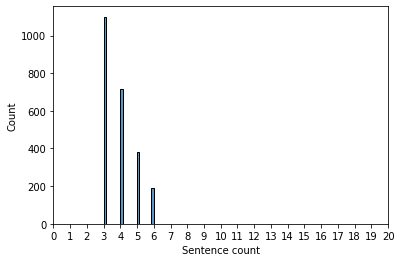

Abel Fernández VALIDATION
min length = 3 sentences
mean length = 3.8197278911564627 sentences
max length = 6 sentences


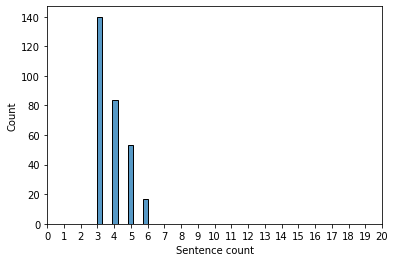

Abel Fernández TEST
min length = 3 sentences
mean length = 3.7660377358490567 sentences
max length = 6 sentences


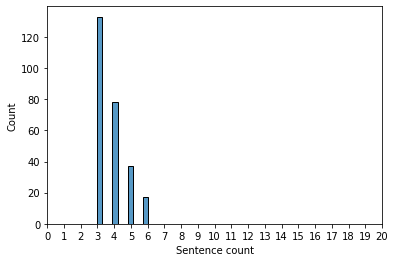

Akın Aydın TRAIN
min length = 3 sentences
mean length = 4.081307627829003 sentences
max length = 6 sentences


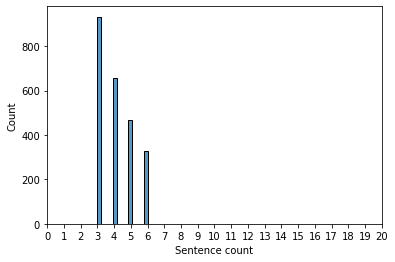

Akın Aydın VALIDATION
min length = 3 sentences
mean length = 4.084745762711864 sentences
max length = 6 sentences


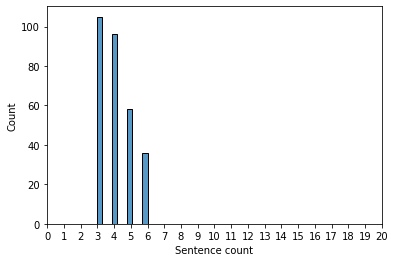

Akın Aydın TEST
min length = 3 sentences
mean length = 4.011320754716981 sentences
max length = 6 sentences


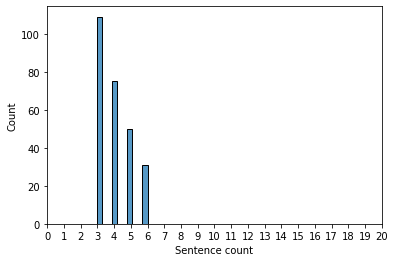

Aziz Karaca TRAIN
min length = 3 sentences
mean length = 3.657915057915058 sentences
max length = 6 sentences


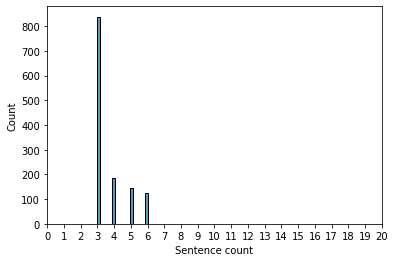

Aziz Karaca VALIDATION
min length = 3 sentences
mean length = 3.61875 sentences
max length = 6 sentences


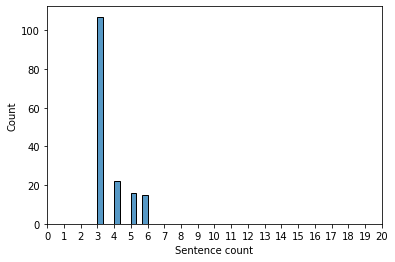

Aziz Karaca TEST
min length = 3 sentences
mean length = 3.4583333333333335 sentences
max length = 6 sentences


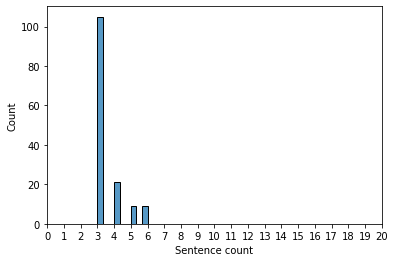

Burhanettin Duran TRAIN
min length = 3 sentences
mean length = 4.2407407407407405 sentences
max length = 6 sentences


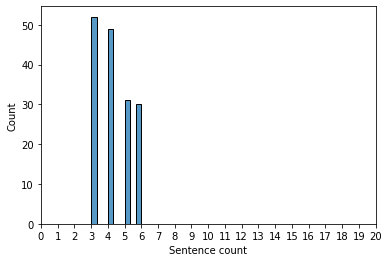

Burhanettin Duran VALIDATION
min length = 3 sentences
mean length = 4.4 sentences
max length = 6 sentences


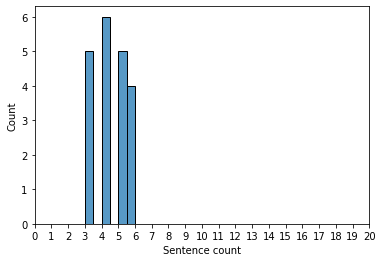

Burhanettin Duran TEST
min length = 3 sentences
mean length = 3.8333333333333335 sentences
max length = 6 sentences


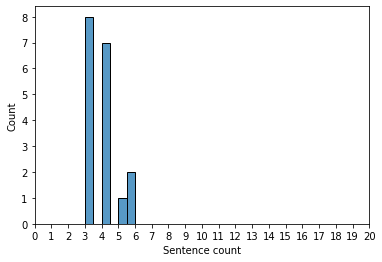

Enrique Navarro TRAIN
min length = 3 sentences
mean length = 3.8673870333988214 sentences
max length = 6 sentences


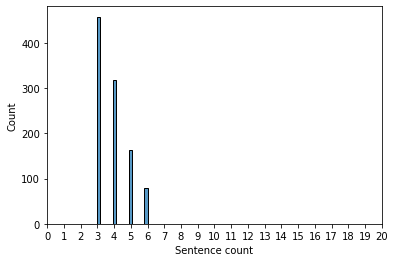

Enrique Navarro VALIDATION
min length = 3 sentences
mean length = 3.8 sentences
max length = 6 sentences


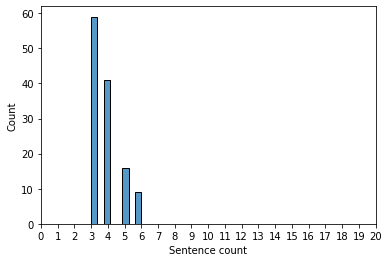

Enrique Navarro TEST
min length = 3 sentences
mean length = 4.008849557522124 sentences
max length = 6 sentences


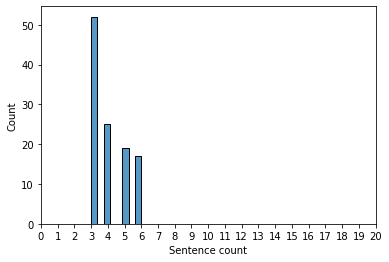

Frank Blenz TRAIN
min length = 3 sentences
mean length = 4.525619834710744 sentences
max length = 6 sentences


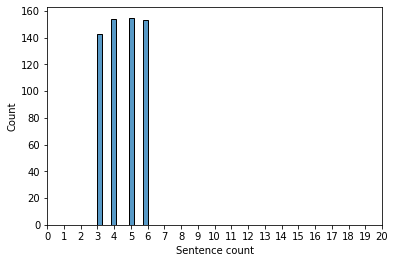

Frank Blenz VALIDATION
min length = 3 sentences
mean length = 4.391891891891892 sentences
max length = 6 sentences


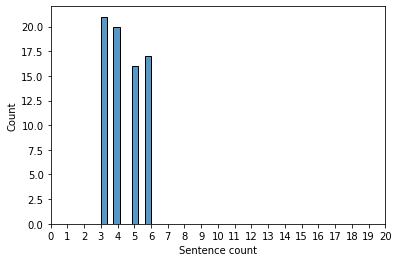

Frank Blenz TEST
min length = 3 sentences
mean length = 4.343283582089552 sentences
max length = 6 sentences


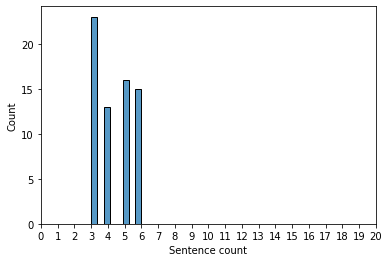

Gerhard Wirth TRAIN
min length = 3 sentences
mean length = 4.118608549874266 sentences
max length = 6 sentences


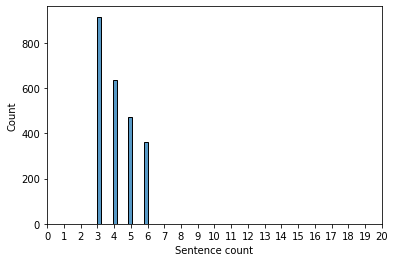

Gerhard Wirth VALIDATION
min length = 3 sentences
mean length = 4.061016949152543 sentences
max length = 6 sentences


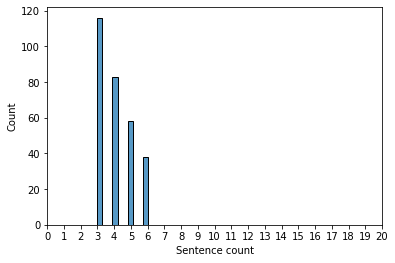

Gerhard Wirth TEST
min length = 3 sentences
mean length = 4.203773584905661 sentences
max length = 6 sentences


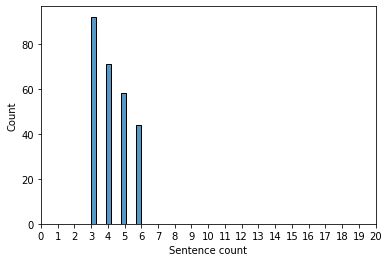

H16 TRAIN
min length = 3 sentences
mean length = 3.4165583008235805 sentences
max length = 6 sentences


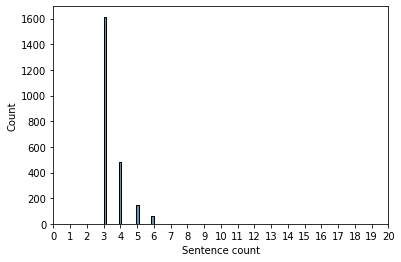

H16 VALIDATION
min length = 3 sentences
mean length = 3.3929824561403508 sentences
max length = 6 sentences


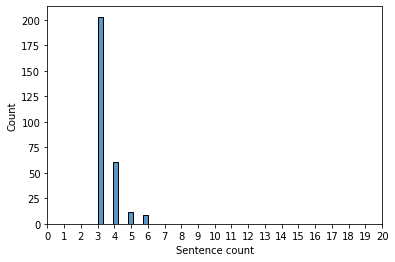

H16 TEST
min length = 3 sentences
mean length = 3.4296875 sentences
max length = 6 sentences


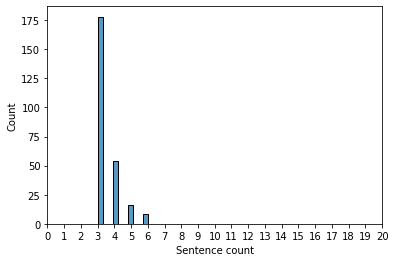

Ivan Rioufol TRAIN
min length = 3 sentences
mean length = 4.249158249158249 sentences
max length = 6 sentences


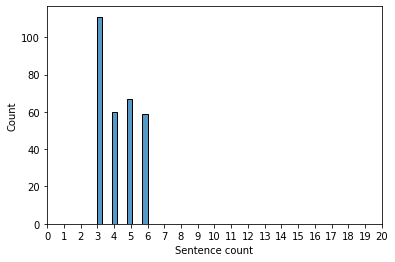

Ivan Rioufol VALIDATION
min length = 3 sentences
mean length = 4.243243243243243 sentences
max length = 6 sentences


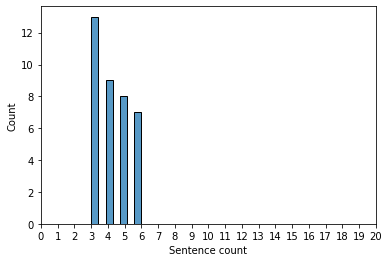

Ivan Rioufol TEST
min length = 3 sentences
mean length = 4.303030303030303 sentences
max length = 6 sentences


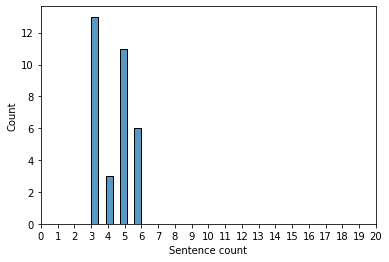

Jean-Luc Mélenchon TRAIN
min length = 3 sentences
mean length = 4.634115674769489 sentences
max length = 6 sentences


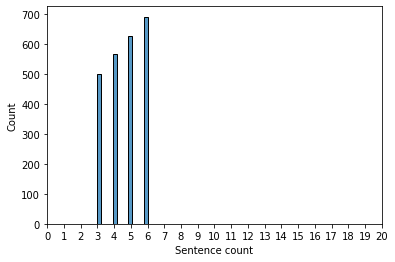

Jean-Luc Mélenchon VALIDATION
min length = 3 sentences
mean length = 4.603389830508474 sentences
max length = 6 sentences


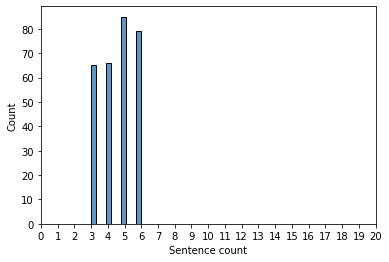

Jean-Luc Mélenchon TEST
min length = 3 sentences
mean length = 4.50188679245283 sentences
max length = 6 sentences


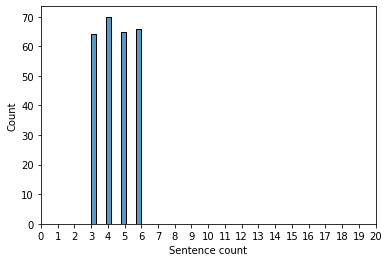

John Redwood TRAIN
min length = 3 sentences
mean length = 3.8738474434199497 sentences
max length = 6 sentences


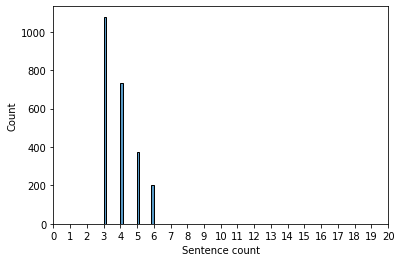

John Redwood VALIDATION
min length = 3 sentences
mean length = 3.922033898305085 sentences
max length = 6 sentences


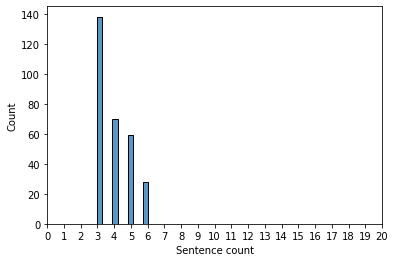

John Redwood TEST
min length = 3 sentences
mean length = 3.7471698113207546 sentences
max length = 6 sentences


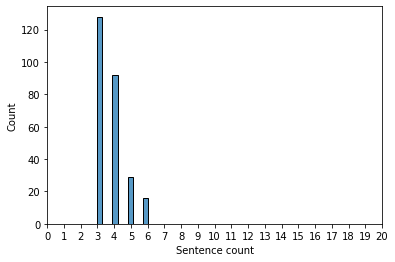

José García Domínguez TRAIN
min length = 3 sentences
mean length = 4.546551724137931 sentences
max length = 6 sentences


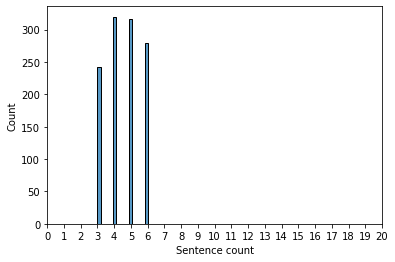

José García Domínguez VALIDATION
min length = 3 sentences
mean length = 4.678321678321678 sentences
max length = 6 sentences


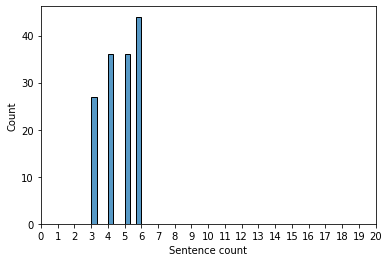

José García Domínguez TEST
min length = 3 sentences
mean length = 4.48062015503876 sentences
max length = 6 sentences


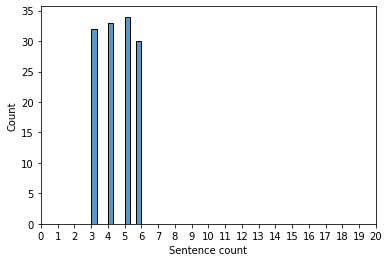

Mario Luis Fuentes TRAIN
min length = 3 sentences
mean length = 3.4214285714285713 sentences
max length = 6 sentences


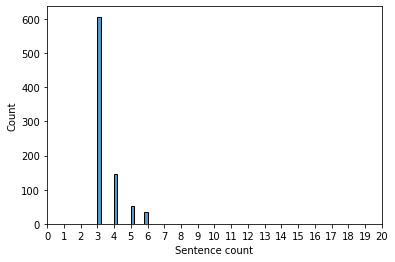

Mario Luis Fuentes VALIDATION
min length = 3 sentences
mean length = 3.480769230769231 sentences
max length = 6 sentences


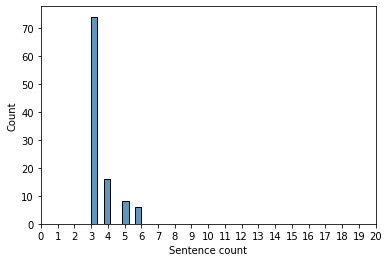

Mario Luis Fuentes TEST
min length = 3 sentences
mean length = 3.4574468085106385 sentences
max length = 6 sentences


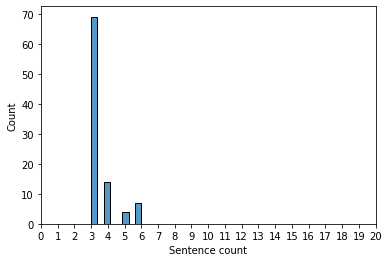

Markos Moulitsas TRAIN
min length = 3 sentences
mean length = 3.895641240569992 sentences
max length = 6 sentences


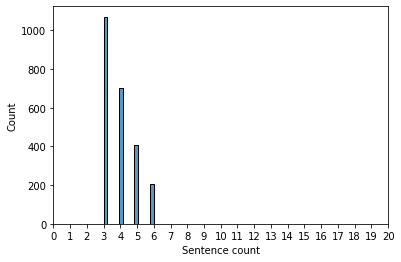

Markos Moulitsas VALIDATION
min length = 3 sentences
mean length = 3.871186440677966 sentences
max length = 6 sentences


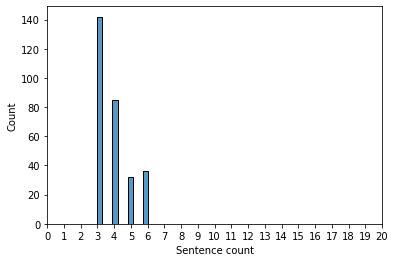

Markos Moulitsas TEST
min length = 3 sentences
mean length = 3.9245283018867925 sentences
max length = 6 sentences


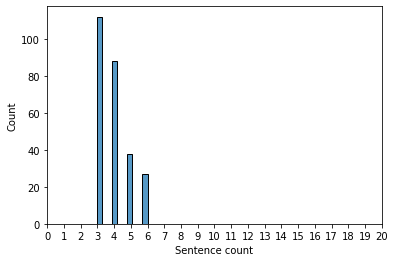

Markus Beckedahl TRAIN
min length = 3 sentences
mean length = 3.9083123425692694 sentences
max length = 6 sentences


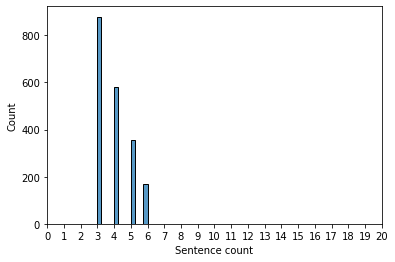

Markus Beckedahl VALIDATION
min length = 3 sentences
mean length = 3.8081632653061224 sentences
max length = 6 sentences


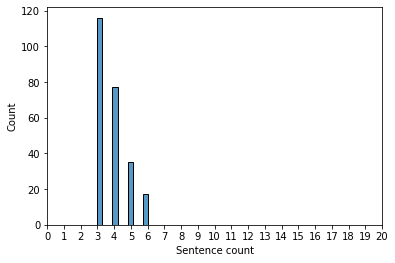

Markus Beckedahl TEST
min length = 3 sentences
mean length = 3.819004524886878 sentences
max length = 6 sentences


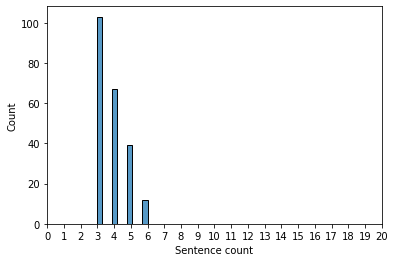

Mike Small TRAIN
min length = 3 sentences
mean length = 3.6860854987426657 sentences
max length = 6 sentences


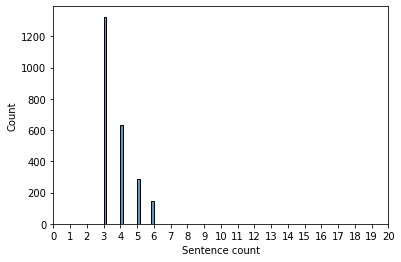

Mike Small VALIDATION
min length = 3 sentences
mean length = 3.772881355932203 sentences
max length = 6 sentences


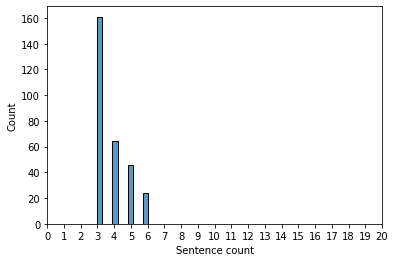

Mike Small TEST
min length = 3 sentences
mean length = 3.7962264150943397 sentences
max length = 6 sentences


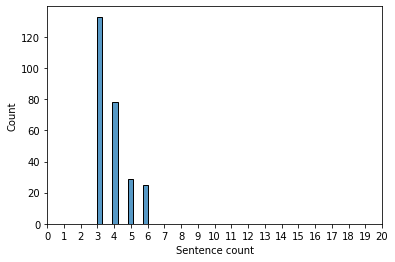

Oral Çalışlar TRAIN
min length = 3 sentences
mean length = 4.094300083822297 sentences
max length = 6 sentences


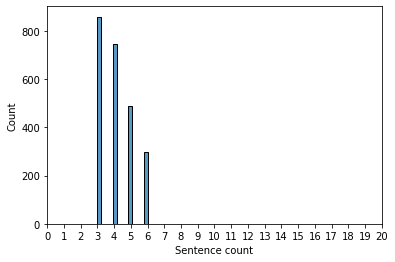

Oral Çalışlar VALIDATION
min length = 3 sentences
mean length = 3.9457627118644067 sentences
max length = 6 sentences


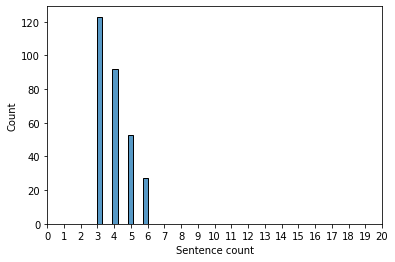

Oral Çalışlar TEST
min length = 3 sentences
mean length = 4.007547169811321 sentences
max length = 6 sentences


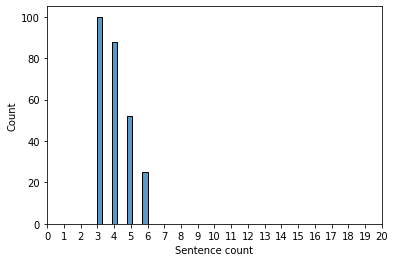

Rachael Swindon TRAIN
min length = 3 sentences
mean length = 3.4953703703703702 sentences
max length = 6 sentences


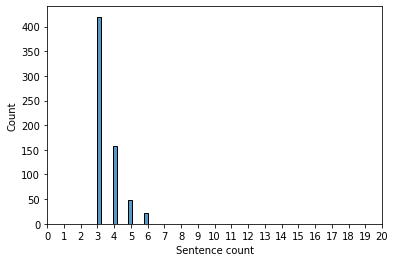

Rachael Swindon VALIDATION
min length = 3 sentences
mean length = 3.425 sentences
max length = 6 sentences


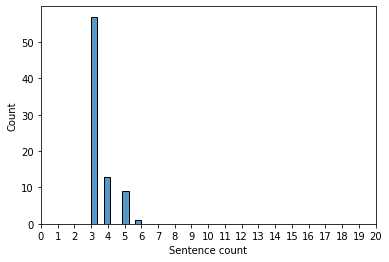

Rachael Swindon TEST
min length = 3 sentences
mean length = 3.4583333333333335 sentences
max length = 6 sentences


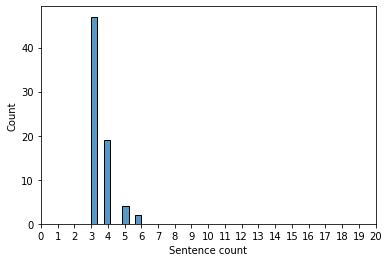

Reinhard Weisener TRAIN
min length = 3 sentences
mean length = 4.125 sentences
max length = 6 sentences


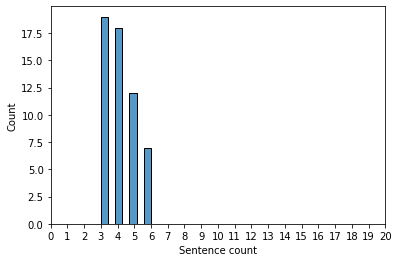

Reinhard Weisener VALIDATION
min length = 3 sentences
mean length = 4.857142857142857 sentences
max length = 6 sentences


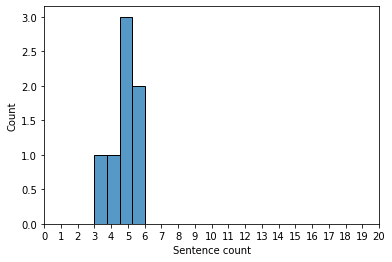

Reinhard Weisener TEST
min length = 3 sentences
mean length = 4.666666666666667 sentences
max length = 6 sentences


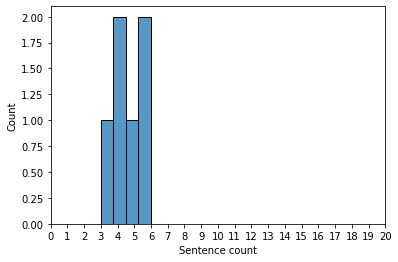

Rich Lowry TRAIN
min length = 3 sentences
mean length = 3.697635135135135 sentences
max length = 6 sentences


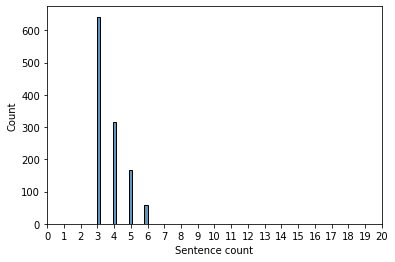

Rich Lowry VALIDATION
min length = 3 sentences
mean length = 3.6232876712328768 sentences
max length = 6 sentences


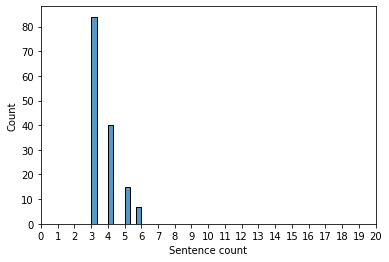

Rich Lowry TEST
min length = 3 sentences
mean length = 3.6515151515151514 sentences
max length = 6 sentences


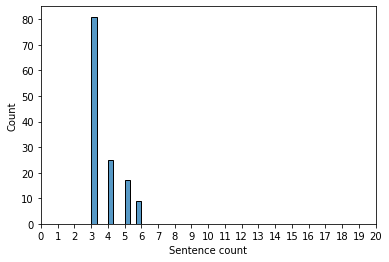

Roberto Gargarella TRAIN
min length = 3 sentences
mean length = 4.017458777885548 sentences
max length = 6 sentences


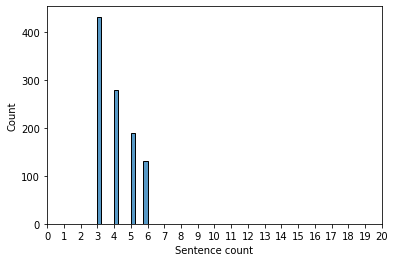

Roberto Gargarella VALIDATION
min length = 3 sentences
mean length = 4.070866141732283 sentences
max length = 6 sentences


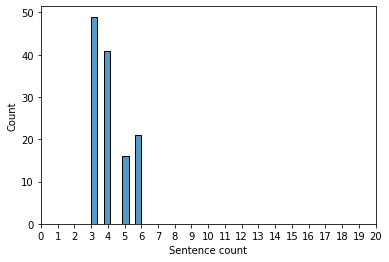

Roberto Gargarella TEST
min length = 3 sentences
mean length = 3.8173913043478263 sentences
max length = 6 sentences


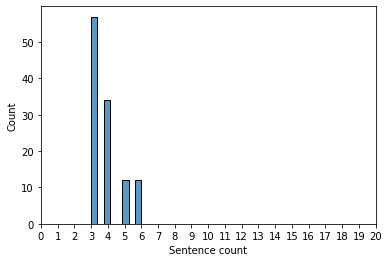

Rod Dreher TRAIN
min length = 3 sentences
mean length = 4.168901927912825 sentences
max length = 6 sentences


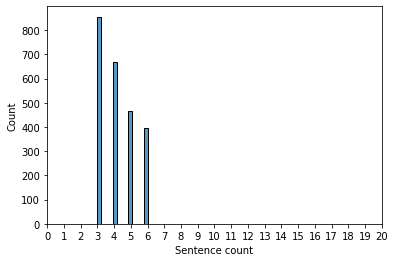

Rod Dreher VALIDATION
min length = 3 sentences
mean length = 4.033898305084746 sentences
max length = 6 sentences


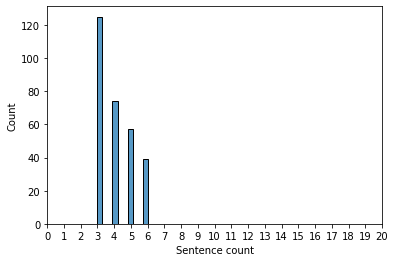

Rod Dreher TEST
min length = 3 sentences
mean length = 4.109433962264151 sentences
max length = 6 sentences


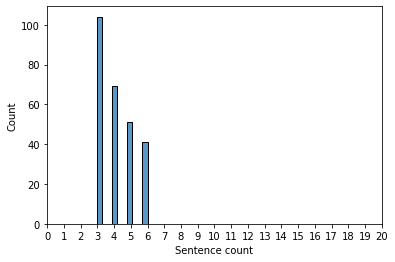

Ronald Brownstein TRAIN
min length = 3 sentences
mean length = 3.659824046920821 sentences
max length = 6 sentences


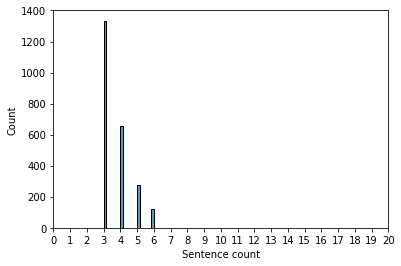

Ronald Brownstein VALIDATION
min length = 3 sentences
mean length = 3.6904761904761907 sentences
max length = 6 sentences


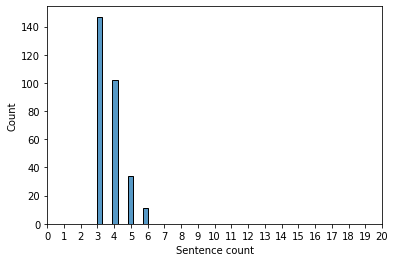

Ronald Brownstein TEST
min length = 3 sentences
mean length = 3.641509433962264 sentences
max length = 6 sentences


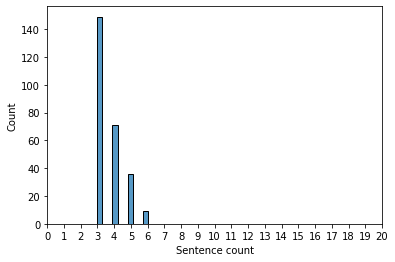

Rusty Weiss TRAIN
min length = 3 sentences
mean length = 3.2149122807017543 sentences
max length = 6 sentences


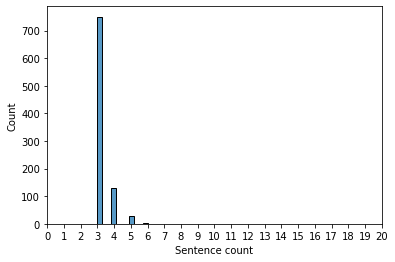

Rusty Weiss VALIDATION
min length = 3 sentences
mean length = 3.1875 sentences
max length = 5 sentences


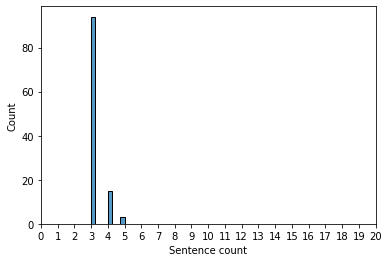

Rusty Weiss TEST
min length = 3 sentences
mean length = 3.107843137254902 sentences
max length = 4 sentences


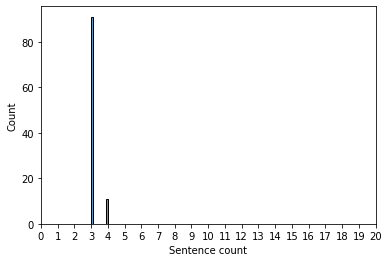

Sarah Jones TRAIN
min length = 3 sentences
mean length = 3.484046692607004 sentences
max length = 6 sentences


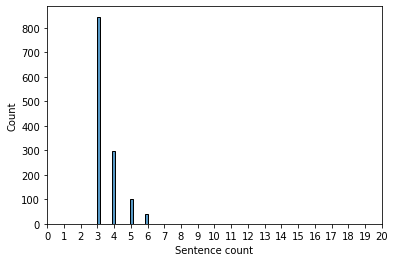

Sarah Jones VALIDATION
min length = 3 sentences
mean length = 3.5534591194968552 sentences
max length = 6 sentences


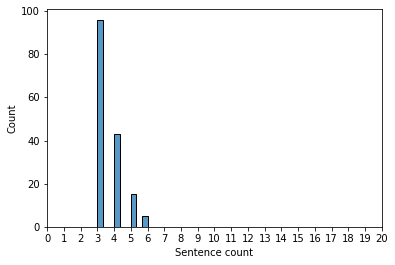

Sarah Jones TEST
min length = 3 sentences
mean length = 3.4615384615384617 sentences
max length = 6 sentences


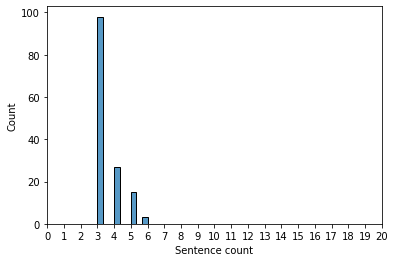

Александр Коваленко TRAIN
min length = 3 sentences
mean length = 3.575859178541492 sentences
max length = 6 sentences


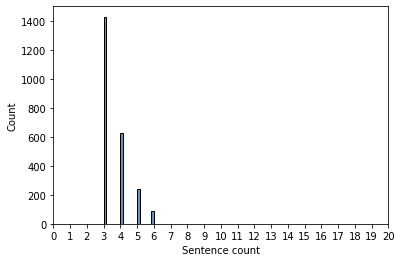

Александр Коваленко VALIDATION
min length = 3 sentences
mean length = 3.606779661016949 sentences
max length = 6 sentences


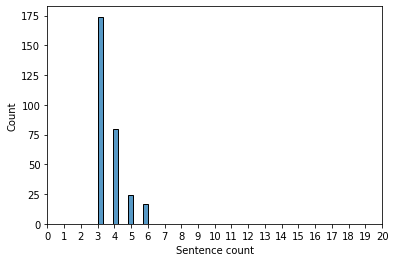

Александр Коваленко TEST
min length = 3 sentences
mean length = 3.569811320754717 sentences
max length = 6 sentences


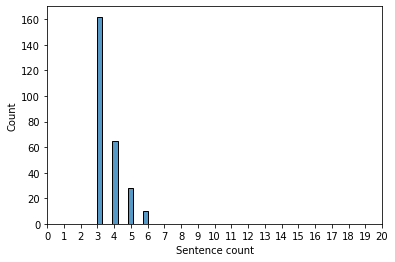

Александр Проханов TRAIN
min length = 3 sentences
mean length = 4.182237117720988 sentences
max length = 6 sentences


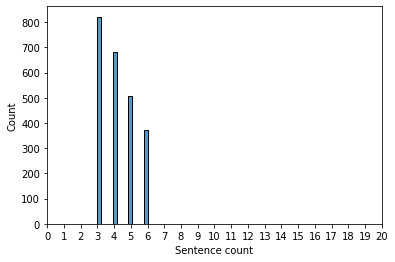

Александр Проханов VALIDATION
min length = 3 sentences
mean length = 4.26530612244898 sentences
max length = 6 sentences


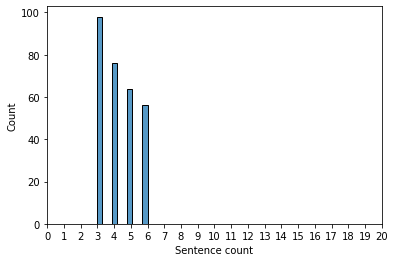

Александр Проханов TEST
min length = 3 sentences
mean length = 4.316981132075472 sentences
max length = 6 sentences


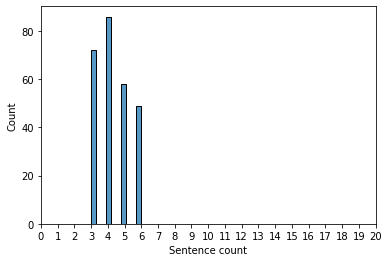

Александра Маринина TRAIN
min length = 3 sentences
mean length = 3.996648512777545 sentences
max length = 6 sentences


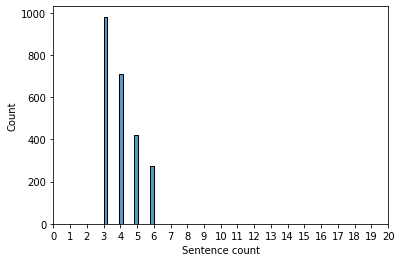

Александра Маринина VALIDATION
min length = 3 sentences
mean length = 3.935374149659864 sentences
max length = 6 sentences


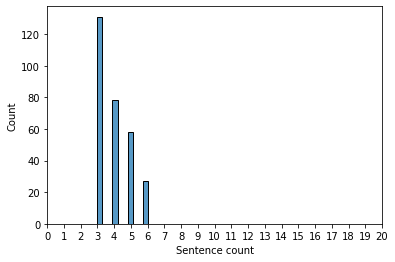

Александра Маринина TEST
min length = 3 sentences
mean length = 4.0150943396226415 sentences
max length = 6 sentences


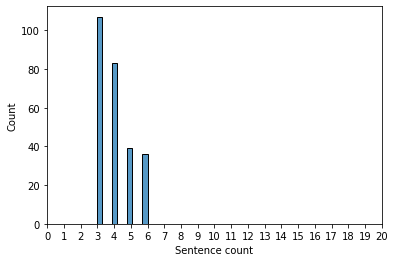

Андрій Карпов TRAIN
min length = 3 sentences
mean length = 4.068825910931174 sentences
max length = 6 sentences


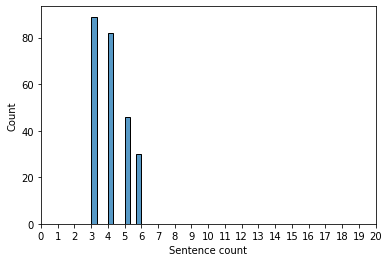

Андрій Карпов VALIDATION
min length = 3 sentences
mean length = 4.3 sentences
max length = 6 sentences


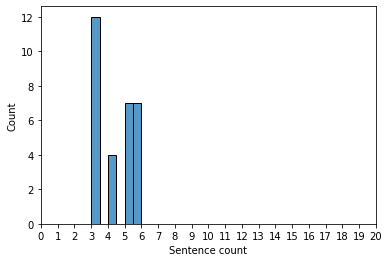

Андрій Карпов TEST
min length = 3 sentences
mean length = 3.892857142857143 sentences
max length = 6 sentences


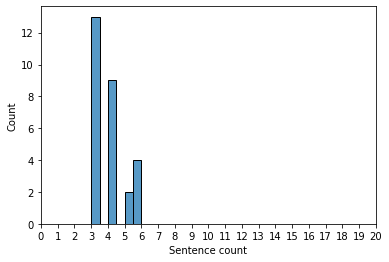

Артемий Лебедев TRAIN
min length = 3 sentences
mean length = 3.708298407376362 sentences
max length = 6 sentences


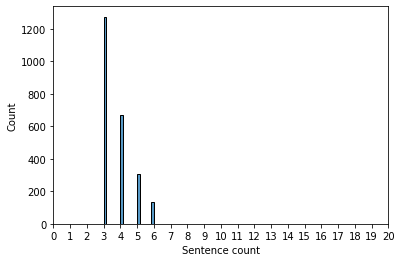

Артемий Лебедев VALIDATION
min length = 3 sentences
mean length = 3.701694915254237 sentences
max length = 6 sentences


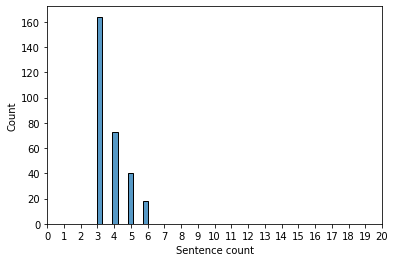

Артемий Лебедев TEST
min length = 3 sentences
mean length = 3.7773584905660376 sentences
max length = 6 sentences


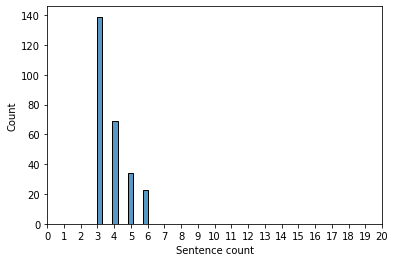

Борис Рожин TRAIN
min length = 3 sentences
mean length = 3.878457669740151 sentences
max length = 6 sentences


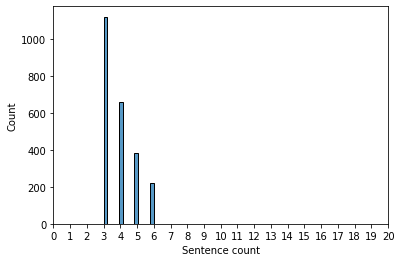

Борис Рожин VALIDATION
min length = 3 sentences
mean length = 3.8983050847457625 sentences
max length = 6 sentences


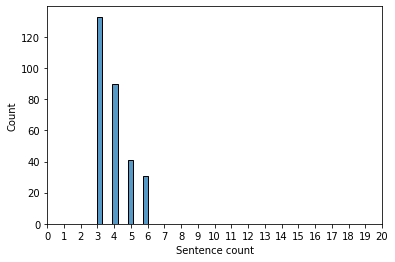

Борис Рожин TEST
min length = 3 sentences
mean length = 3.9622641509433962 sentences
max length = 6 sentences


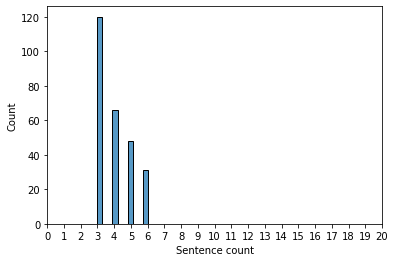

Верола TRAIN
min length = 3 sentences
mean length = 3.936295054484493 sentences
max length = 6 sentences


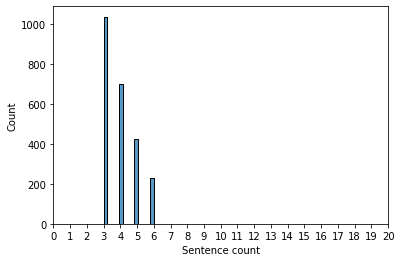

Верола VALIDATION
min length = 3 sentences
mean length = 4.013559322033898 sentences
max length = 6 sentences


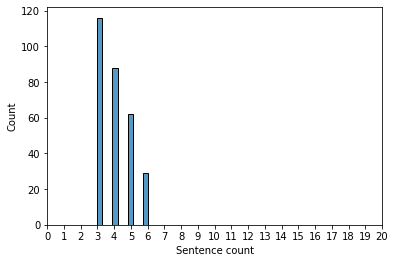

Верола TEST
min length = 3 sentences
mean length = 3.879245283018868 sentences
max length = 6 sentences


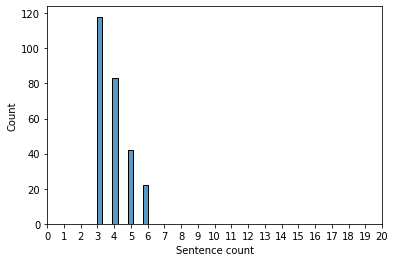

Виктор Пелевин TRAIN
min length = 3 sentences
mean length = 3.9295892707460185 sentences
max length = 6 sentences


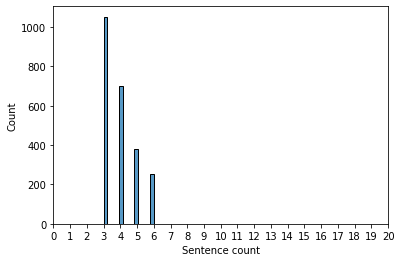

Виктор Пелевин VALIDATION
min length = 3 sentences
mean length = 3.935593220338983 sentences
max length = 6 sentences


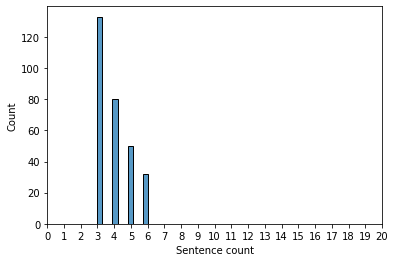

Виктор Пелевин TEST
min length = 3 sentences
mean length = 3.9622641509433962 sentences
max length = 6 sentences


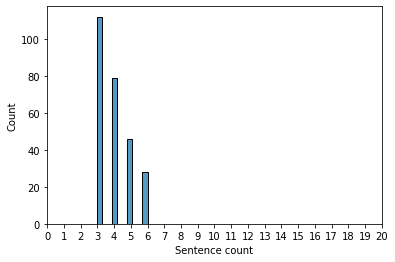

Данило Гетманцев TRAIN
min length = 3 sentences
mean length = 4.591809775429327 sentences
max length = 6 sentences


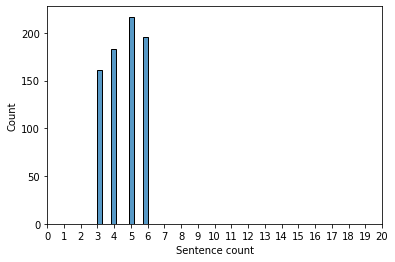

Данило Гетманцев VALIDATION
min length = 3 sentences
mean length = 4.655913978494624 sentences
max length = 6 sentences


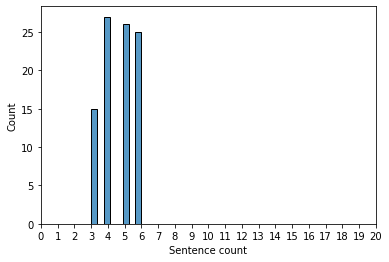

Данило Гетманцев TEST
min length = 3 sentences
mean length = 4.416666666666667 sentences
max length = 6 sentences


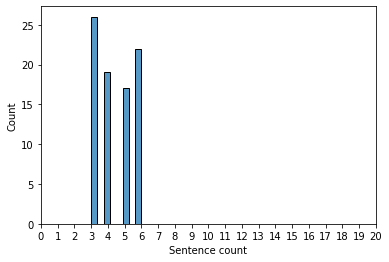

Дарья Донцова TRAIN
min length = 3 sentences
mean length = 3.989103101424979 sentences
max length = 6 sentences


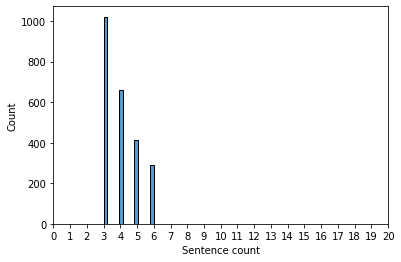

Дарья Донцова VALIDATION
min length = 3 sentences
mean length = 3.9016949152542373 sentences
max length = 6 sentences


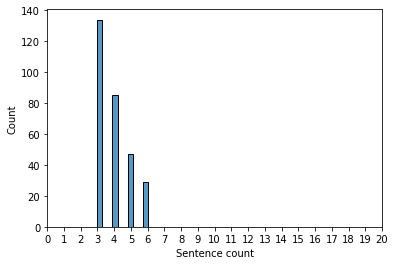

Дарья Донцова TEST
min length = 3 sentences
mean length = 3.9320754716981132 sentences
max length = 6 sentences


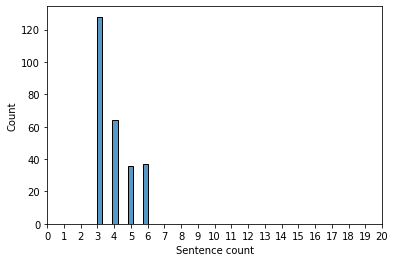

Дмитрий Пучков TRAIN
min length = 3 sentences
mean length = 3.842857142857143 sentences
max length = 6 sentences


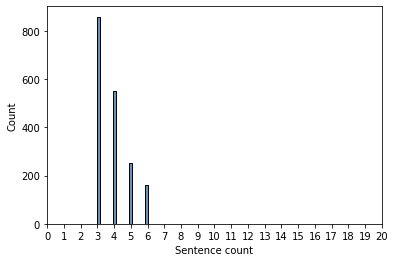

Дмитрий Пучков VALIDATION
min length = 3 sentences
mean length = 3.8482142857142856 sentences
max length = 6 sentences


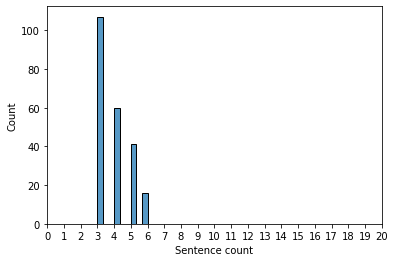

Дмитрий Пучков TEST
min length = 3 sentences
mean length = 3.8514851485148514 sentences
max length = 6 sentences


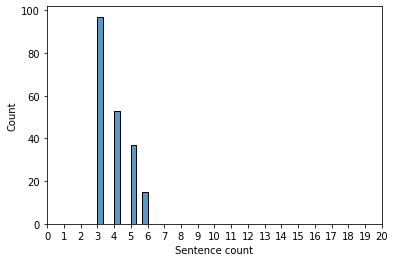

Захар Прилепин TRAIN
min length = 3 sentences
mean length = 3.7678122380553227 sentences
max length = 6 sentences


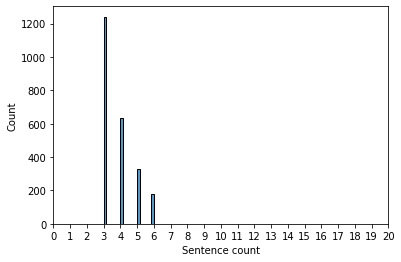

Захар Прилепин VALIDATION
min length = 3 sentences
mean length = 3.7491525423728813 sentences
max length = 6 sentences


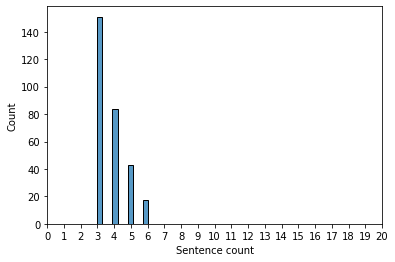

Захар Прилепин TEST
min length = 3 sentences
mean length = 3.860377358490566 sentences
max length = 6 sentences


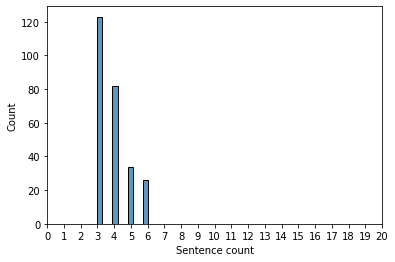

Илья Варламов TRAIN
min length = 3 sentences
mean length = 3.9953897736797988 sentences
max length = 6 sentences


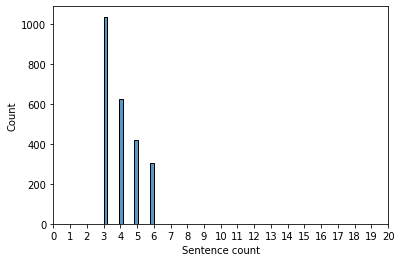

Илья Варламов VALIDATION
min length = 3 sentences
mean length = 3.9491525423728815 sentences
max length = 6 sentences


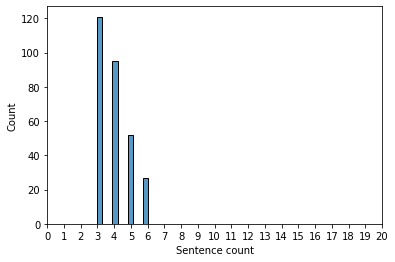

Илья Варламов TEST
min length = 3 sentences
mean length = 3.9547169811320755 sentences
max length = 6 sentences


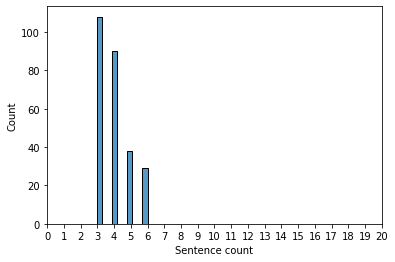

Максим Кац TRAIN
min length = 3 sentences
mean length = 3.548197820620285 sentences
max length = 6 sentences


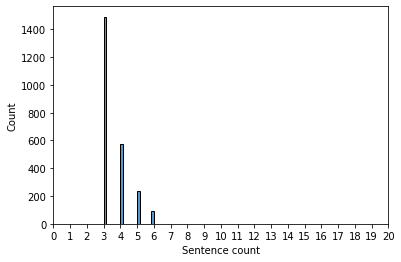

Максим Кац VALIDATION
min length = 3 sentences
mean length = 3.549152542372881 sentences
max length = 6 sentences


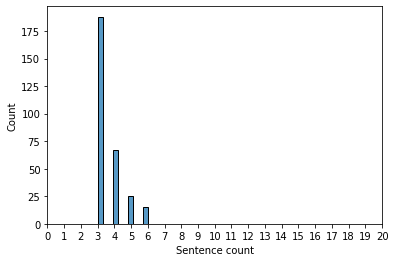

Максим Кац TEST
min length = 3 sentences
mean length = 3.4452830188679244 sentences
max length = 6 sentences


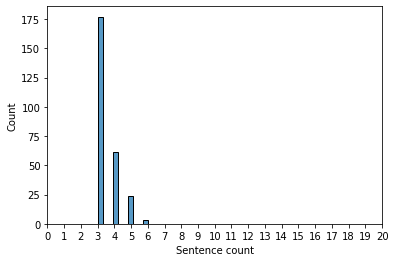

Олексій Гончаренко TRAIN
min length = 3 sentences
mean length = 4.249790444258172 sentences
max length = 6 sentences


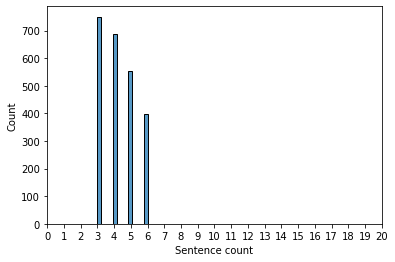

Олексій Гончаренко VALIDATION
min length = 3 sentences
mean length = 4.288135593220339 sentences
max length = 6 sentences


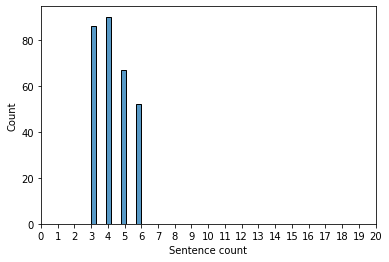

Олексій Гончаренко TEST
min length = 3 sentences
mean length = 4.1773584905660375 sentences
max length = 6 sentences


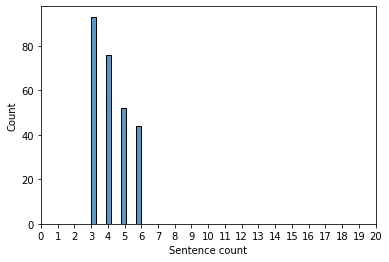

Олексій Петров TRAIN
min length = 3 sentences
mean length = 4.27319587628866 sentences
max length = 6 sentences


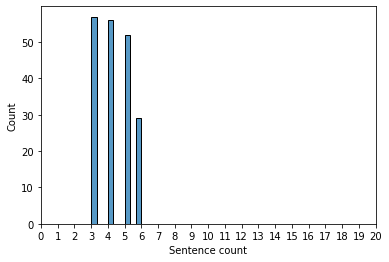

Олексій Петров VALIDATION
min length = 3 sentences
mean length = 4.625 sentences
max length = 6 sentences


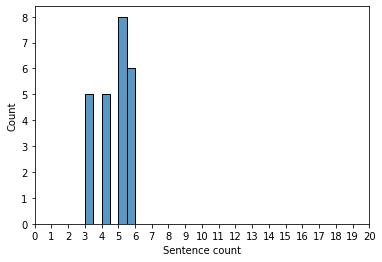

Олексій Петров TEST
min length = 3 sentences
mean length = 4.181818181818182 sentences
max length = 6 sentences


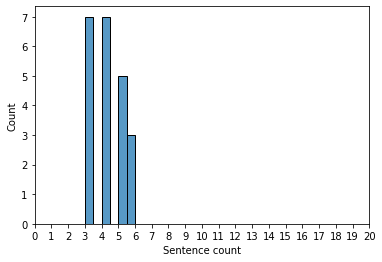

Олена Монова TRAIN
min length = 3 sentences
mean length = 4.251282051282051 sentences
max length = 6 sentences


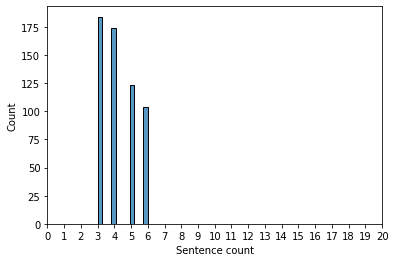

Олена Монова VALIDATION
min length = 3 sentences
mean length = 4.375 sentences
max length = 6 sentences


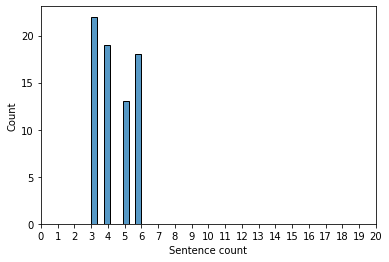

Олена Монова TEST
min length = 3 sentences
mean length = 4.2153846153846155 sentences
max length = 6 sentences


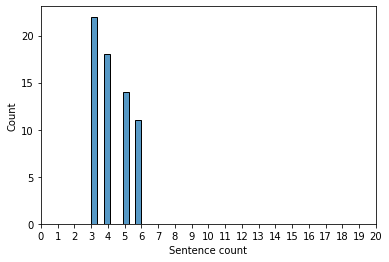

Роман Вінтонів TRAIN
min length = 3 sentences
mean length = 4.031852472757754 sentences
max length = 6 sentences


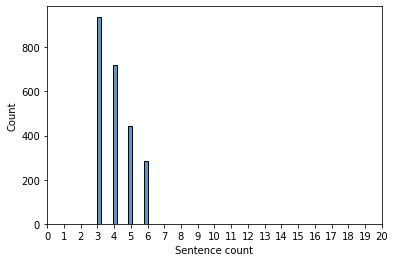

Роман Вінтонів VALIDATION
min length = 3 sentences
mean length = 3.993220338983051 sentences
max length = 6 sentences


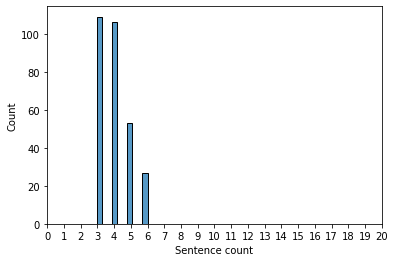

Роман Вінтонів TEST
min length = 3 sentences
mean length = 4.090566037735849 sentences
max length = 6 sentences


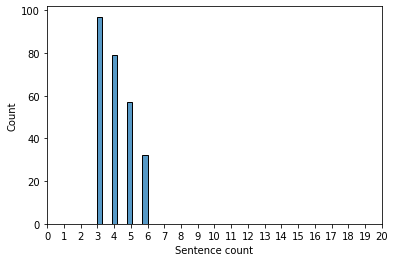

Роман Донiк TRAIN
min length = 3 sentences
mean length = 4.446927374301676 sentences
max length = 6 sentences


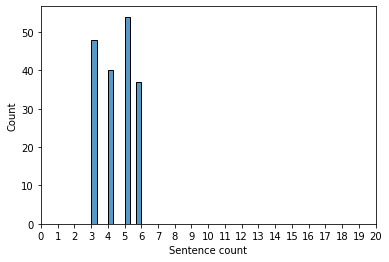

Роман Донiк VALIDATION
min length = 3 sentences
mean length = 4.545454545454546 sentences
max length = 6 sentences


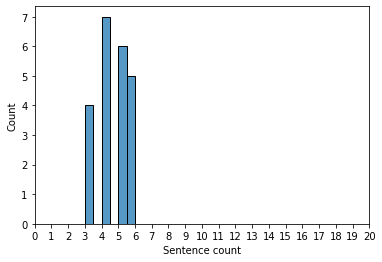

Роман Донiк TEST
min length = 3 sentences
mean length = 4.5 sentences
max length = 6 sentences


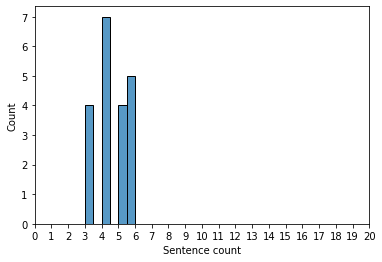

Сергій Притула TRAIN
min length = 3 sentences
mean length = 4.631229235880399 sentences
max length = 6 sentences


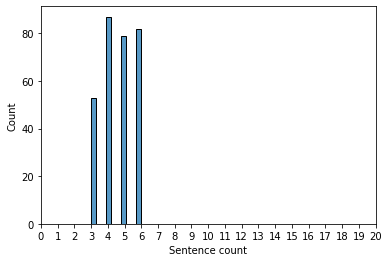

Сергій Притула VALIDATION
min length = 3 sentences
mean length = 4.72972972972973 sentences
max length = 6 sentences


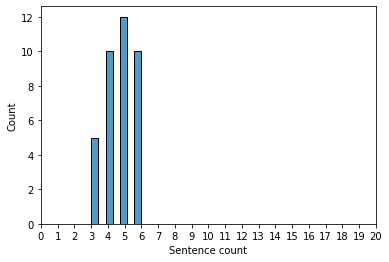

Сергій Притула TEST
min length = 3 sentences
mean length = 4.529411764705882 sentences
max length = 6 sentences


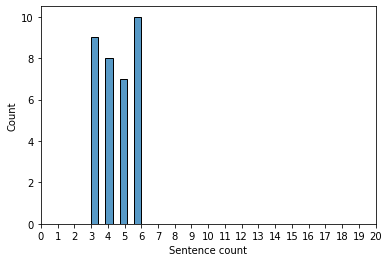

Сергій Стерненко TRAIN
min length = 3 sentences
mean length = 4.0704107292539815 sentences
max length = 6 sentences


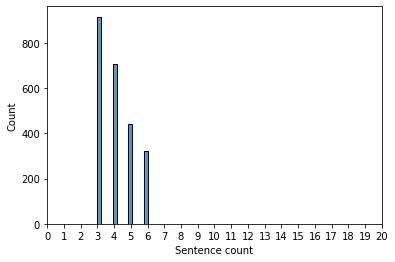

Сергій Стерненко VALIDATION
min length = 3 sentences
mean length = 4.0067796610169495 sentences
max length = 6 sentences


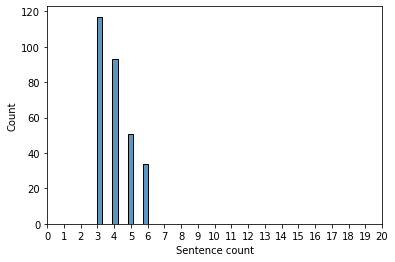

Сергій Стерненко TEST
min length = 3 sentences
mean length = 4.0452830188679245 sentences
max length = 6 sentences


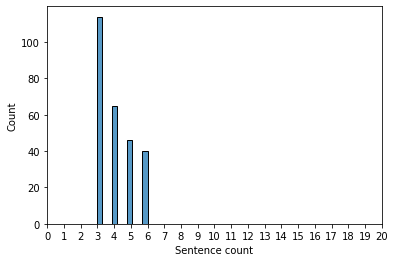

Старославянский TRAIN
min length = 3 sentences
mean length = 3.0843373493975905 sentences
max length = 5 sentences


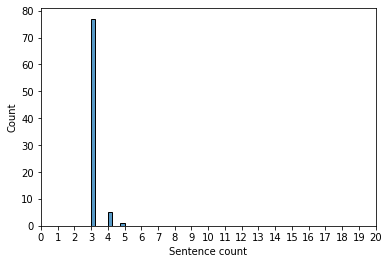

Старославянский VALIDATION
min length = 3 sentences
mean length = 3.2 sentences
max length = 5 sentences


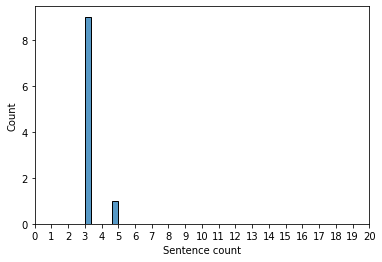

Старославянский TEST
min length = 3 sentences
mean length = 3.111111111111111 sentences
max length = 4 sentences


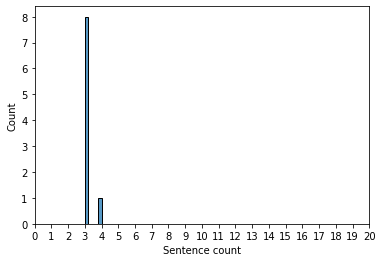

Татьяна Андрющенко TRAIN
min length = 3 sentences
mean length = 3.716380393799749 sentences
max length = 6 sentences


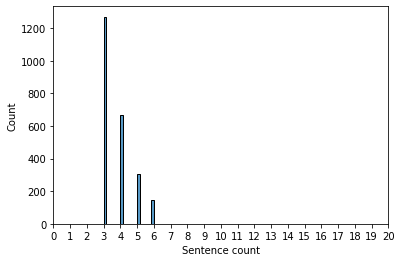

Татьяна Андрющенко VALIDATION
min length = 3 sentences
mean length = 3.683673469387755 sentences
max length = 6 sentences


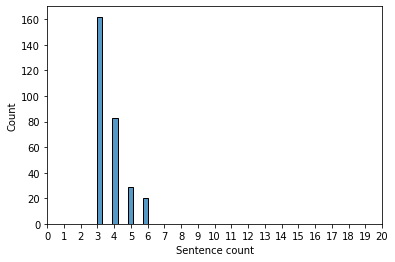

Татьяна Андрющенко TEST
min length = 3 sentences
mean length = 3.6339622641509433 sentences
max length = 6 sentences


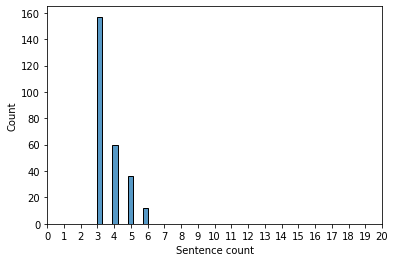

Федор Достоевский TRAIN
min length = 3 sentences
mean length = 4.030176026823135 sentences
max length = 6 sentences


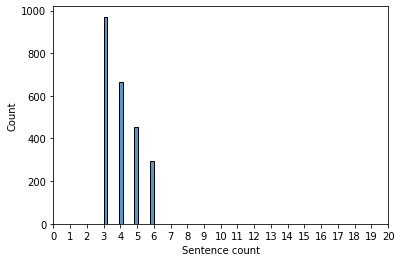

Федор Достоевский VALIDATION
min length = 3 sentences
mean length = 4.030508474576271 sentences
max length = 6 sentences


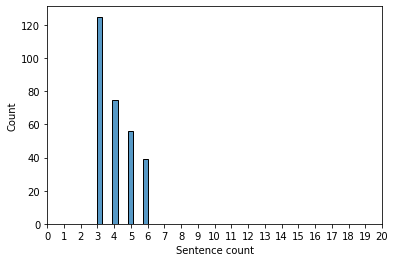

Федор Достоевский TEST
min length = 3 sentences
mean length = 3.943396226415094 sentences
max length = 6 sentences


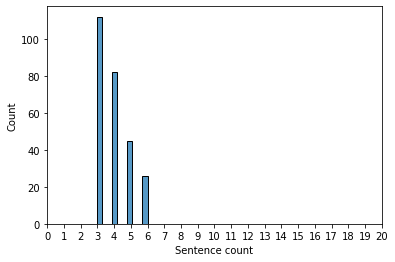

Эдуард Лимонов TRAIN
min length = 3 sentences
mean length = 4.179798826487846 sentences
max length = 6 sentences


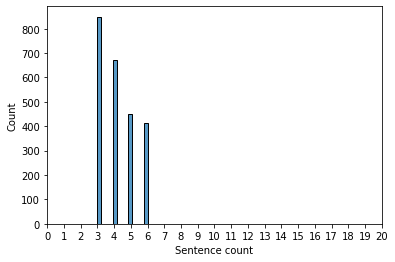

Эдуард Лимонов VALIDATION
min length = 3 sentences
mean length = 4.271186440677966 sentences
max length = 6 sentences


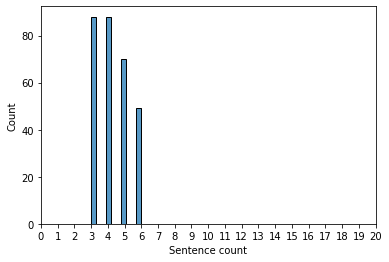

Эдуард Лимонов TEST
min length = 3 sentences
mean length = 4.162264150943396 sentences
max length = 6 sentences


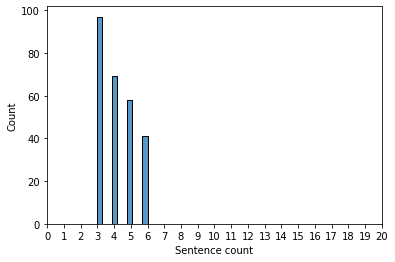

Юрий Подоляка TRAIN
min length = 3 sentences
mean length = 3.951403435274403 sentences
max length = 6 sentences


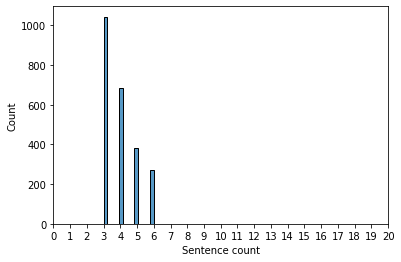

Юрий Подоляка VALIDATION
min length = 3 sentences
mean length = 3.9285714285714284 sentences
max length = 6 sentences


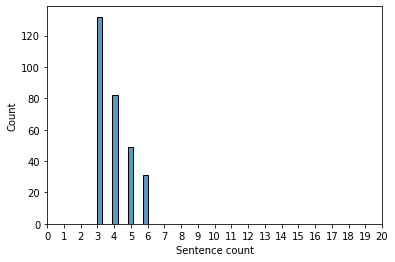

Юрий Подоляка TEST
min length = 3 sentences
mean length = 3.871698113207547 sentences
max length = 6 sentences


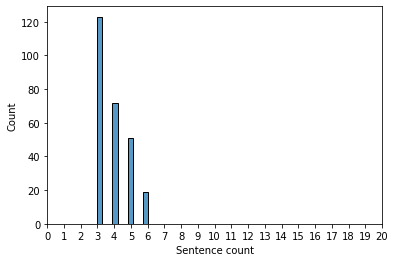

Яна Кубаева TRAIN
min length = 3 sentences
mean length = 3.901089689857502 sentences
max length = 6 sentences


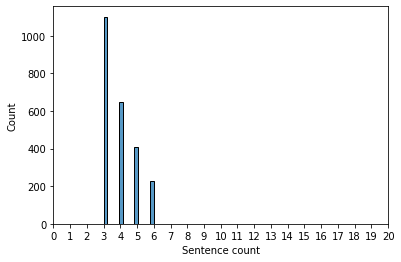

Яна Кубаева VALIDATION
min length = 3 sentences
mean length = 3.776271186440678 sentences
max length = 6 sentences


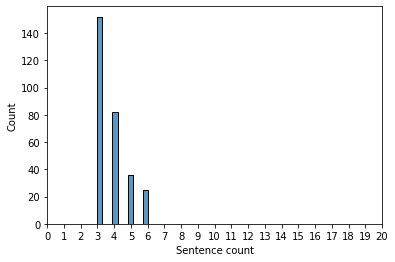

Яна Кубаева TEST
min length = 3 sentences
mean length = 3.90188679245283 sentences
max length = 6 sentences


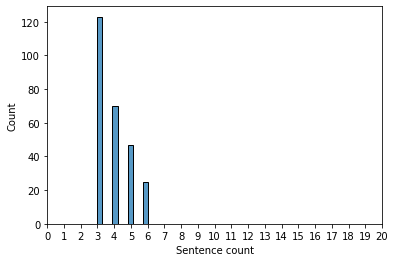

Яна Франк TRAIN
min length = 3 sentences
mean length = 4.092204526404023 sentences
max length = 6 sentences


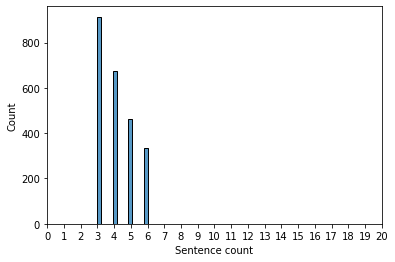

Яна Франк VALIDATION
min length = 3 sentences
mean length = 4.077966101694916 sentences
max length = 6 sentences


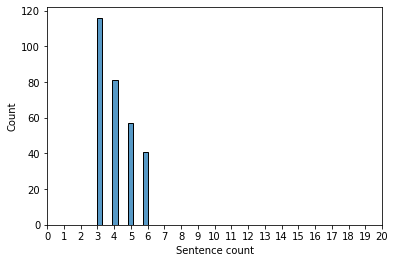

Яна Франк TEST
min length = 3 sentences
mean length = 4.0754716981132075 sentences
max length = 6 sentences


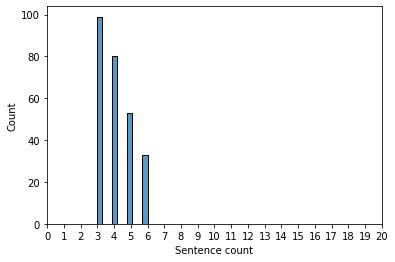

Яніна Соколова TRAIN
min length = 3 sentences
mean length = 3.8998682476943345 sentences
max length = 6 sentences


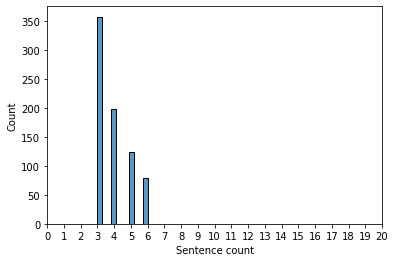

Яніна Соколова VALIDATION
min length = 3 sentences
mean length = 3.913978494623656 sentences
max length = 6 sentences


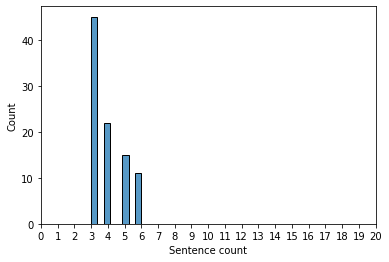

Яніна Соколова TEST
min length = 3 sentences
mean length = 3.8452380952380953 sentences
max length = 6 sentences


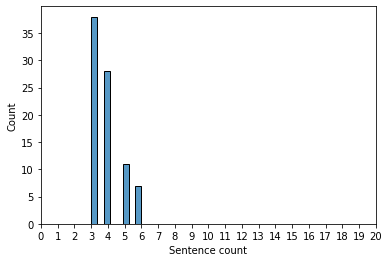

سري سمور TRAIN
min length = 3 sentences
mean length = 3.345971563981043 sentences
max length = 6 sentences


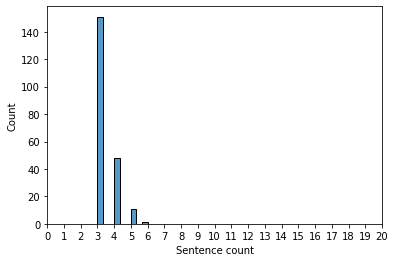

سري سمور VALIDATION
min length = 3 sentences
mean length = 3.5384615384615383 sentences
max length = 6 sentences


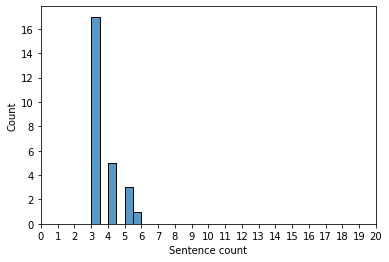

سري سمور TEST
min length = 3 sentences
mean length = 3.4166666666666665 sentences
max length = 6 sentences


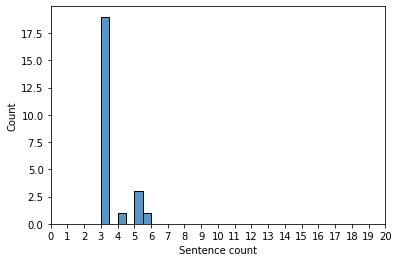

سليمان صالح TRAIN
min length = 3 sentences
mean length = 3.090909090909091 sentences
max length = 5 sentences


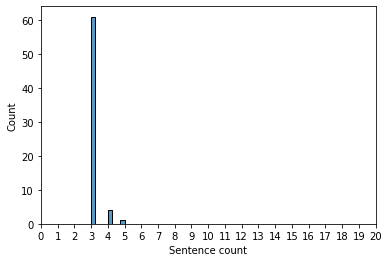

سليمان صالح VALIDATION
min length = 3 sentences
mean length = 3.375 sentences
max length = 4 sentences


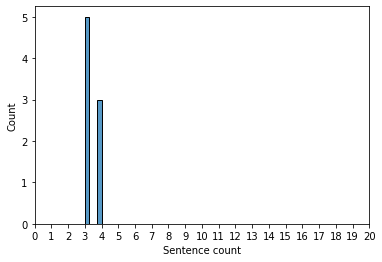

سليمان صالح TEST
min length = 3 sentences
mean length = 3.25 sentences
max length = 4 sentences


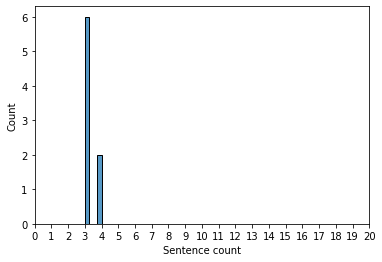

علي الصلابي TRAIN
min length = 3 sentences
mean length = 3.536096256684492 sentences
max length = 6 sentences


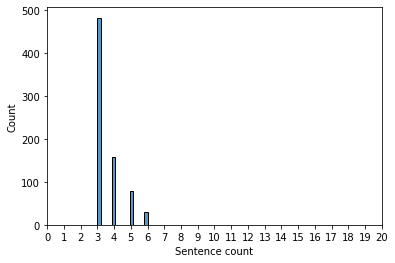

علي الصلابي VALIDATION
min length = 3 sentences
mean length = 3.5869565217391304 sentences
max length = 6 sentences


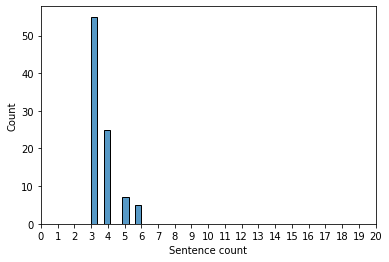

علي الصلابي TEST
min length = 3 sentences
mean length = 3.4096385542168677 sentences
max length = 6 sentences


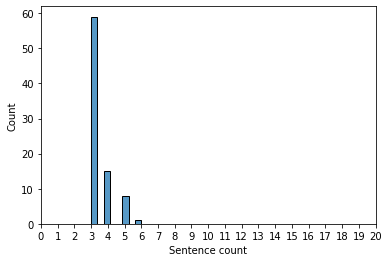

محمود عبد الهادي TRAIN
min length = 3 sentences
mean length = 3.399390243902439 sentences
max length = 6 sentences


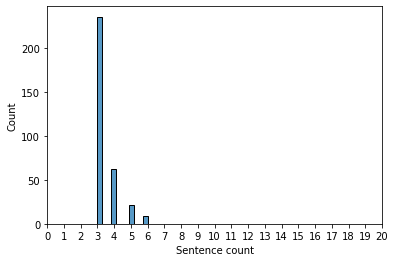

محمود عبد الهادي VALIDATION
min length = 3 sentences
mean length = 3.375 sentences
max length = 5 sentences


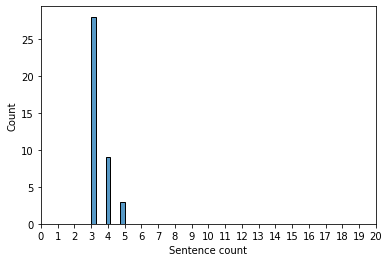

محمود عبد الهادي TEST
min length = 3 sentences
mean length = 3.4864864864864864 sentences
max length = 6 sentences


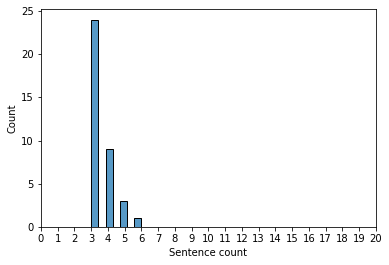

ياسر عبدالعزيز TRAIN
min length = 3 sentences
mean length = 3.2333333333333334 sentences
max length = 5 sentences


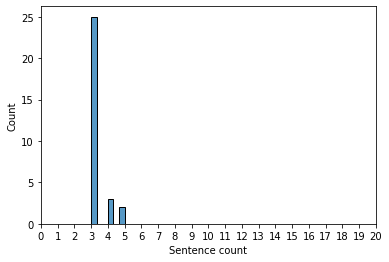

ياسر عبدالعزيز VALIDATION
min length = 3 sentences
mean length = 3 sentences
max length = 3 sentences


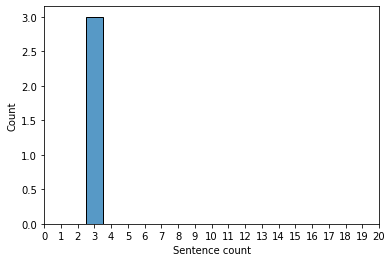

ياسر عبدالعزيز TEST
min length = 3 sentences
mean length = 4 sentences
max length = 5 sentences


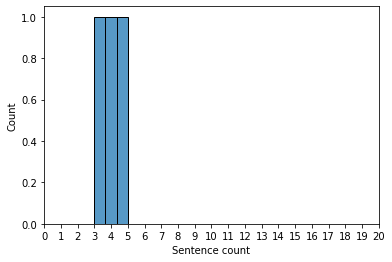

In [ ]:
for group_train, group_val, group_test  in zip(df_train.groupby('author'), df_val.groupby('author'),df_test.groupby('author')):
    print(group_train[0], "TRAIN")
    token_len(get_token_len(list(group_train[1]['text'])))
    print(group_val[0], "VALIDATION")
    token_len(get_token_len(list(group_val[1]['text'])))
    print(group_test[0], "TEST")
    token_len(get_token_len(list(group_test[1]['text'])))

# Подготовка данных

In [12]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

print(f'train_dataset:\n\n{train_dataset}')

train_dataset:

Dataset({
    features: ['text', 'author', 'label'],
    num_rows: 12114
})


In [13]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        max_length=max_len,
        padding='max_length',
        truncation='longest_first'
    )

In [14]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

Map:   0%|          | 0/12114 [00:00<?, ? examples/s]

Map:   0%|          | 0/1496 [00:00<?, ? examples/s]

Map:   0%|          | 0/1346 [00:00<?, ? examples/s]

In [15]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [18]:
test_dataset[0]

{'label': tensor(12),
 'input_ids': tensor([     0,      6, 246309,  79500,      6, 228250,  15755,  43132,  59389,
          39050,  55701,  51013,  49921,    591, 183834,    129,  77123,    969,
           1047,  51597, 225486, 208485,     89,  28069,  16641,  79562,     61,
          72392,  23495,   7762, 105404,     49,   8044,    260,      5,      6,
         245711, 246025,  10042,  77123, 225486,  53326,  11551,    969,   1047,
          51597, 228814,     89,   2513,      5,  17040, 129364, 232685, 228814,
             59, 177858,     49,   3707,      5,   2592,      5,  48400,   2681,
              6,  38151,      4,  31050,    255,  37715,  30161, 228814,     59,
         177858,     61,  20144,  20049,  16662,      4,    899, 194384,    989,
           6367,   1711,  21218,      5,  90917,   1595,  20144,  20049,  24032,
           3273,  25903, 142084,  39959,      4,  53331,  25903,  89318,    695,
         142084,      4,  14909, 160522,   1009, 170904,      4, 142084,  

# Загрузка модели и обучение

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=num_author)

Some weights of the model checkpoint at intfloat/multilingual-e5-large were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at intfloat/multilingual-e5-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on

In [16]:
def compute_metrics(pred):
    '''Функция возвращает метрики качества'''
    labels = pred.label_ids
    preds = [p.argmax() for p in pred.predictions]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_mean': np.mean(f1),
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    save_strategy=save_strategy,
    num_train_epochs=10,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    weight_decay=weight_decay,
    learning_rate=learning_rate,
    logging_dir=logging_dir,
    evaluation_strategy=evaluation_strategy
)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
trainer.train_dataset = train_dataset
trainer.eval_dataset = val_dataset

In [ ]:
start_time = time()

trainer.train()

print(f'Time: {time() - start_time:.1f} sec')

NameError: name 'time' is not defined

# Тестирование

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [17]:
path_to_model = "drive/MyDrive/Colab Notebooks/Классификация авторов/HashingVectorizer/model"

In [24]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.8 MB/s eta 0:00:00


In [18]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=path_to_model, num_labels=num_author, use_safetensors=True)
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics
)

In [19]:
start_time = time()

test_predict_results = trainer.predict(test_dataset)

print(f'predictions:\n{test_predict_results.predictions}')
print(f'\n(true) label_ids:\n{test_predict_results.label_ids}')
print(f'\nmetrics:')
for key, value in test_predict_results.metrics.items():
    print(f'"{key}": {value}')
print(f'\nmacro f1: {np.mean(test_predict_results.metrics["test_f1"])}')

print(f'\nTime: {time() - start_time:.1f} sec')

predictions:
[[-0.27758598 -0.3279857  -0.448721   ... -0.3983032  -1.6020273
  -0.40084746]
 [-0.4248664  -0.12575874 -0.20042108 ... -0.5460837  -0.38788325
  -0.20217344]
 [10.656866   -0.5365687  -0.61960465 ... -1.5373247  -0.8439861
  -0.5092305 ]
 ...
 [10.588221   -0.44681644 -0.619141   ... -1.5508503  -0.6405117
  -0.656389  ]
 [-0.42777333 -1.1102425  -0.87161726 ... -0.45713353 -0.68337417
  -0.25880733]
 [10.672471   -0.7209136  -0.4988272  ... -1.6977553  -0.73401386
  -0.36559325]]

(true) label_ids:
[12  9  0 ...  0  4  0]

metrics:
"test_loss": 0.08678700774908066
"test_accuracy": 0.9843982169390788
"test_f1_mean": 0.985506587522598
"test_f1": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9806451612903225, 1.0, 1.0, 0.9836065573770493, 0.9940828402366864, 0.9456521739130435, 0.9659090909090909, 0.9392265193370165, 0.9680851063829787, 1.0, 0.9863013698630138, 0.975609756097561]
"test_precision": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.987012987012987, 1.0, 1.0, 0.9782608695652174, 1.0, 0.9

In [ ]:
t_np = test_dataset['label'].numpy() #convert to Numpy array
df = pd.DataFrame(t_np) #convert to a dataframe
df.to_csv("test_labels.csv",index=False) #save to file

In [20]:
test_pred = [np.argmax(a) for a in test_predict_results.predictions]

In [ ]:
df = pd.DataFrame(test_pred) #convert to a dataframe
df.to_csv("predictions.csv",index=False) #save to file

In [25]:
authors_labels = list(df_test['author'].unique())

In [26]:
authors_labels.sort()

In [28]:
print(classification_report(test_dataset['label'], test_pred, digits=4, target_names=authors_labels))

                       precision    recall  f1-score   support

       Abel Fernández     1.0000    1.0000    1.0000        91
           Akın Aydın     1.0000    1.0000    1.0000        91
        Gerhard Wirth     1.0000    1.0000    1.0000        91
                  H16     1.0000    1.0000    1.0000        89
   Jean-Luc Mélenchon     1.0000    1.0000    1.0000        75
José García Domínguez     1.0000    1.0000    1.0000        86
     Markos Moulitsas     0.9870    0.9744    0.9806        78
     Markus Beckedahl     1.0000    1.0000    1.0000        32
        Oral Çalışlar     1.0000    1.0000    1.0000        91
           Rod Dreher     0.9783    0.9890    0.9836        91
   Александр Проханов     1.0000    0.9882    0.9941        85
      Артемий Лебедев     0.9355    0.9560    0.9457        91
     Данило Гетманцев     1.0000    0.9341    0.9659        91
       Дмитрий Пучков     0.9444    0.9341    0.9392        91
     Сергій Стерненко     0.9381    1.0000    0.9681  

In [29]:
test_dataset

Dataset({
    features: ['text', 'author', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1346
})

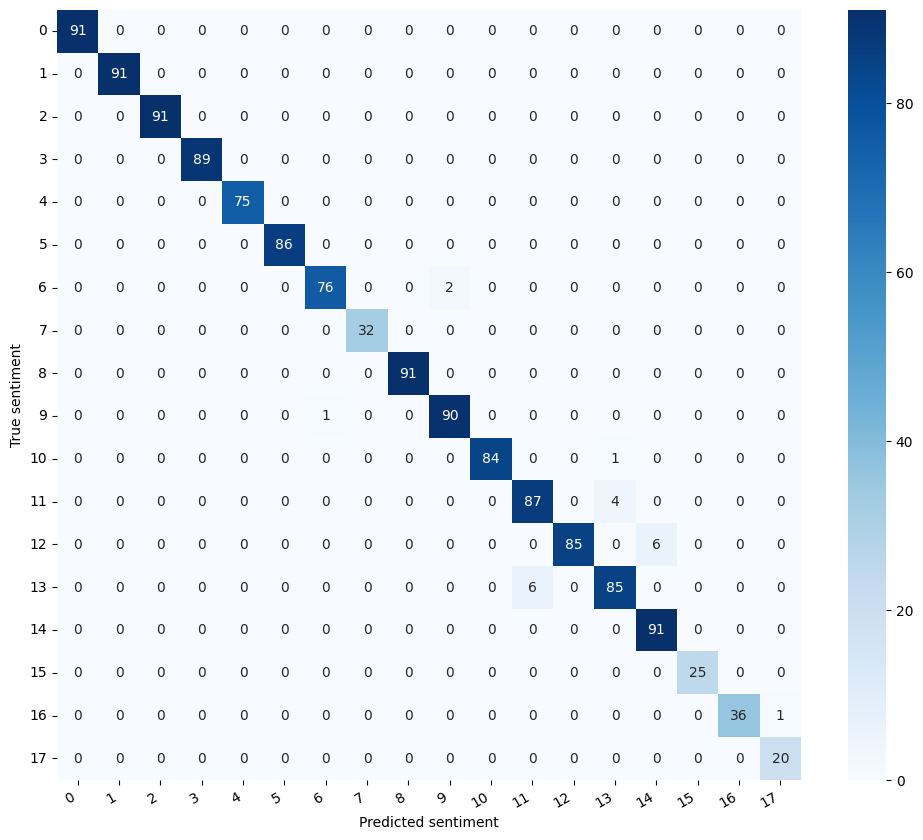

In [30]:
def show_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(12,10))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_dataset['label'], test_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

__Results for 11 authors__

In [ ]:
print(classification_report(test_dataset['label'], test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8776    0.8034    0.8389       473
           1     0.7941    0.8562    0.8240       473
           2     0.7070    0.6786    0.6926       473
           3     0.8079    0.7378    0.7713       473
           4     0.6590    0.6102    0.6337       472
           5     0.8844    0.8414    0.8624       473
           6     0.7034    0.8224    0.7583       473
           7     0.8376    0.7526    0.7929       473
           8     0.8891    0.8816    0.8854       473
           9     0.7878    0.8478    0.8167       473
          10     0.7623    0.8541    0.8056       473

    accuracy                         0.7897      5202
   macro avg     0.7919    0.7897    0.7892      5202
weighted avg     0.7919    0.7897    0.7893      5202



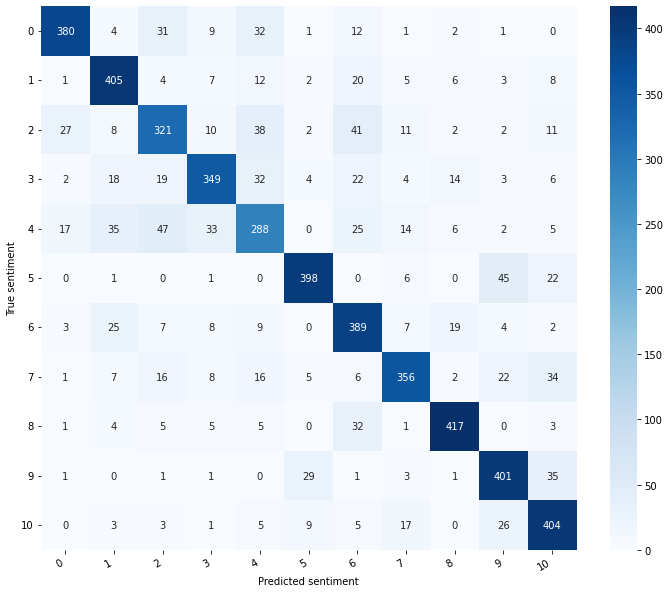

In [ ]:
def show_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(12,10))
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_dataset['label'], test_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)